$$\text{
Importing the Necessary Libraries
}
$$

In [21]:
###-----------------
### Import Libraries
###-----------------
import sys


sys.path.append('../')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

import tensorflow as tf


from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix


$$\text{
Setting Global Varables
}
$$

In [84]:
###----------------
# Global Variables
###----------------


RANDOM_STATE = 0
np.random.seed(RANDOM_STATE)



TEST_SIZE =  0.2
ALPHA = 0.001
EPOCHS = 20
BATCH_SIZE = 32
PATIENCE = 6
LR_FACTOR = 0.1
LR_PATIENCE = 10

# set location of input files and output files
inpDir = '../input'
outDir = '../output'
modelDir = '../models' 
subDir = 'mnist_fashion'


# Set plotting parameters
params = {
    'figure.figsize': (15,4),
    'axes.titlesize': 'large',
    'axes.labelsize': 'medium',
    'legend.fontsize': 'medium',
    'xtick.labelsize': 'medium',
    'ytick.labelsize': 'medium',
}
plt.rcParams.update(params)


CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid')




In [23]:
def accuracy_socre_confusion_matrix(data_ds, prediction_model, labels):
    y_true, y_pred = [], []
    for count, data in enumerate(data_ds):
        feat, label = data
        pred = prediction_model(feat).numpy().argmax(axis=1)
        y_true.extend(label)
        y_pred.extend(pred)
        
    print(len(y_true), len(y_pred))

    print(accuracy_score(y_true=y_true, y_pred=y_pred)*100)

    fn_plot_confusion_matrix(y_true, y_pred, labels=labels)

$$\text{
    Loading the data
}
$$

In [24]:
train_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_train.csv')
valid_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_test.csv')

train_df = pd.read_csv(train_filename, header = 0)
valid_df = pd.read_csv(valid_filename, header = 0)


train_df.shape, valid_df.shape

((60000, 785), (10000, 785))

In [25]:
class_names = {
    0: 'T-shirt/top',
    1:'Trouser',
    2:'Pullover',
    3:'Dress',
    4:'Coat',
    5:'Sandal', 
    6: 'Shirt',
    7: 'Sneaker', 
    8:'Bag', 
    9: 'Ankle boot'
}

In [26]:
train_df.head(3)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0


$$
\text{
    Plot the Images
}$$

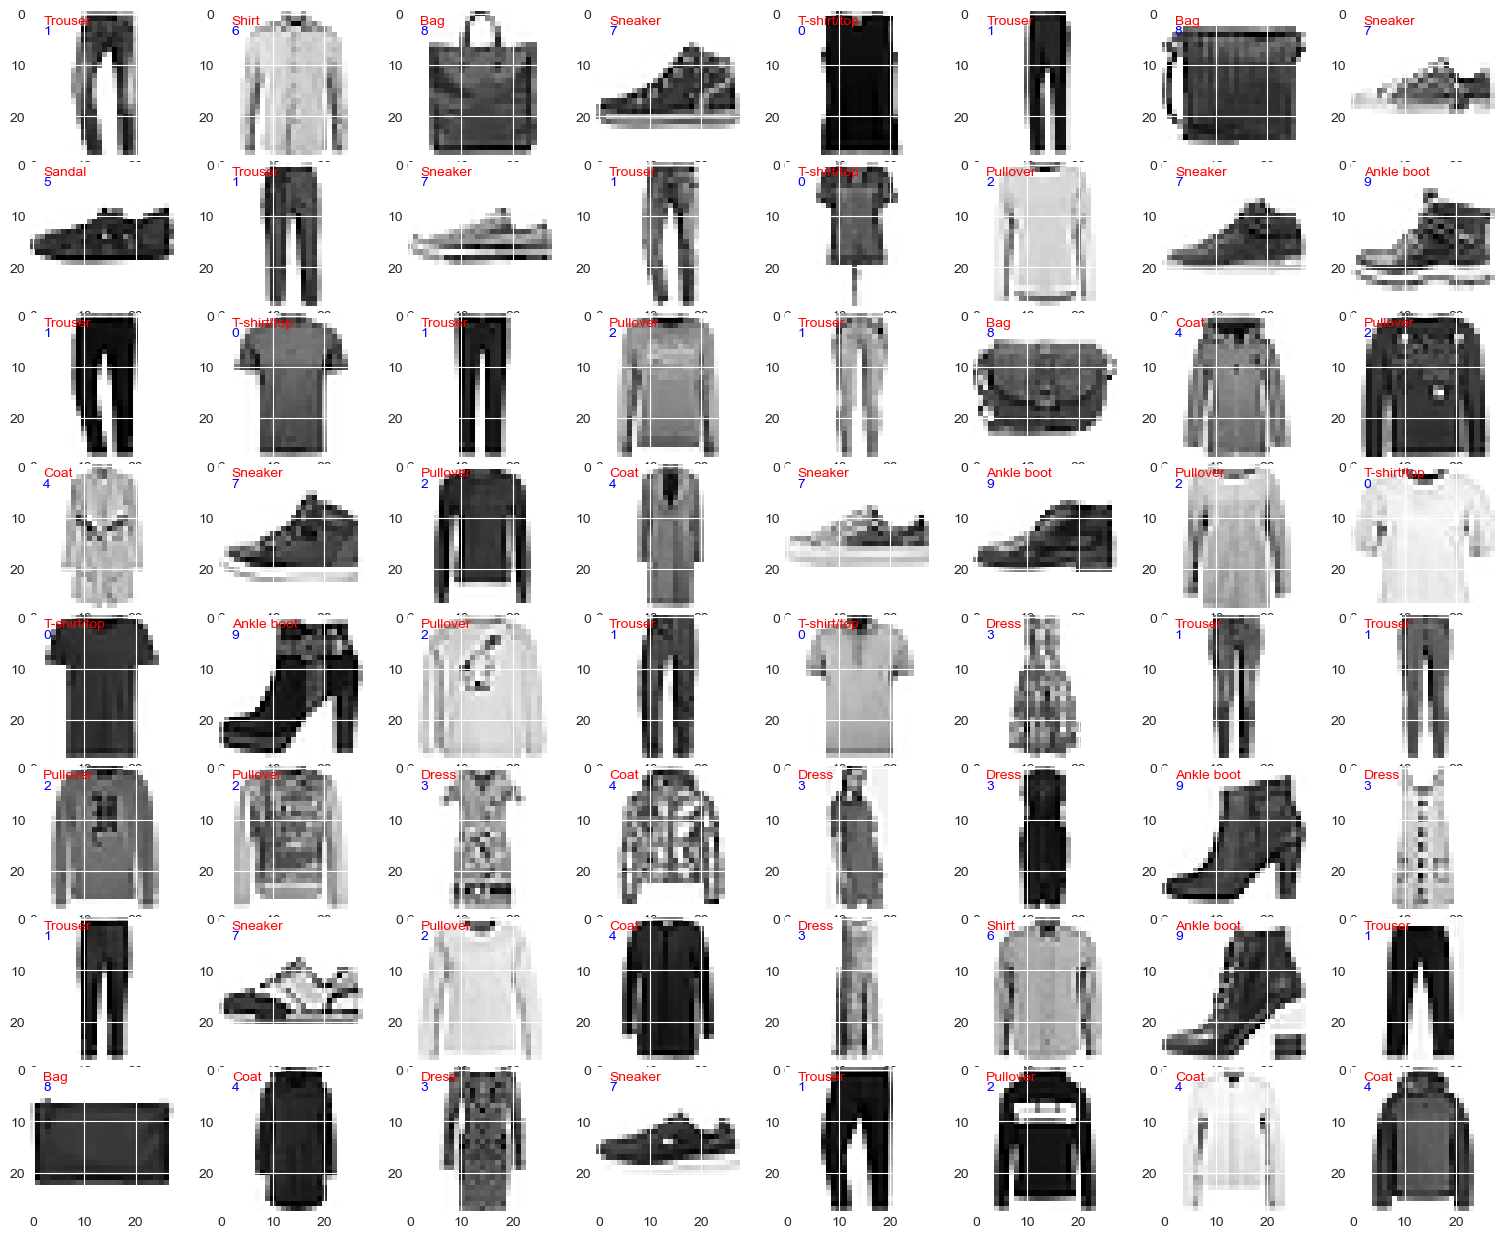

In [27]:
no_rows = 8
no_cols = 8

plot_df = train_df.sample(no_rows*no_cols)

fig = plt.figure(figsize=(15,12))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
i = 0

for idx, row in plot_df.iterrows():
    i += 1
    image  = row.values[1:].reshape(28,28)
    ax = fig.add_subplot(no_rows, no_cols, i)
    ax.imshow(image, cmap=plt.cm.binary, interpolation='nearest')
    ax.text(2,4, str(row.values[0]),color='b', fontsize=10)
    ax.text(2,2, class_names[row.values[0]],color='r', fontsize=10)

plt.show()  


$$\text{
    Train Test Split
}
$$

In [28]:
X_data = train_df.drop(columns=['label'], axis=1).to_numpy()
y_data = train_df['label'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=TEST_SIZE, random_state=RANDOM_STATE)

X_valid = valid_df.drop(columns=['label'], axis=1).to_numpy()
y_valid = valid_df['label'].to_numpy()


X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((48000, 784), (12000, 784), (48000,), (12000,))

$$\text{
    Scaling the Dataset
}
$$

In [29]:
X_train = X_train/255.0
X_test = X_test/255.0
X_valid = X_valid/255.0

$$
\text{
Converting to dataset for batch processing instead of all data training at once
}
$$

In [30]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train,y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test,y_test))
valid_ds = tf.data.Dataset.from_tensor_slices((X_valid,y_valid))

type(train_ds), type(test_ds), type(valid_ds)

(tensorflow.python.data.ops.from_tensor_slices_op._TensorSliceDataset,
 tensorflow.python.data.ops.from_tensor_slices_op._TensorSliceDataset,
 tensorflow.python.data.ops.from_tensor_slices_op._TensorSliceDataset)

In [31]:
train_shape = X_train.shape
test_shape = X_test.shape
valid_shape = X_valid.shape

in_len = train_shape[1]
out_len = len(np.unique(y_train))

In [32]:
import gc

del train_df, valid_df, X_train, y_train, X_test, y_test, X_valid, y_valid
gc.collect()
gc.collect()

0

$$
\text{
    Converting the data to a tensor dataset using Preprocessing and Batching
}
$$

In [33]:
train_ds = train_ds.shuffle(buffer_size = train_shape[0]).batch(BATCH_SIZE)
test_ds = test_ds.shuffle(buffer_size = test_shape[0]).batch(BATCH_SIZE)
valid_ds = valid_ds.shuffle(buffer_size = valid_shape[0]).batch(BATCH_SIZE)

In [34]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [35]:
# ONly for testing
next(iter(train_ds))

(<tf.Tensor: shape=(32, 784), dtype=float64, numpy=
 array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.04313725, 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])>,
 <tf.Tensor: shape=(32,), dtype=int64, numpy=
 array([1, 8, 2, 3, 5, 6, 1, 0, 0, 2, 8, 3, 6, 5, 5, 6, 6, 6, 5, 4, 6, 5,
        4, 5, 9, 9, 5, 2, 7, 1, 3, 6], dtype=int64)>)

$$\text{
    Creating the model
}
$$

**Sequential API**

```python
model = tf.keras.Sequential([
    tf.keras.Input(shape=(in_len,), name = 'input'), 
    tf.keras.layers.Dense(392, activation=tf.keras.activations.relu, name='fc_1'),
    tf.keras.layers.Dense(196, activation=tf.keras.activations.relu, name='fc_2'),
    tf.keras.layers.Dense(98, activation=tf.keras.activations.relu, name='fc_3'),
    tf.keras.layers.Dense(49, activation=tf.keras.activations.relu, name='fc_4'),
    tf.keras.layers.Dense(out_len, name = 'output')
])
````

**Functional API**

In [36]:
# Input
inputs = tf.keras.Input(shape=(784,), name='input')


# Hidden Layer
x = tf.keras.layers.Dense(392, activation=tf.keras.activations.relu, name='fc_1')(inputs)
x = tf.keras.layers.Dense(196, activation=tf.keras.activations.relu, name='fc_2')(x)
x = tf.keras.layers.Dense(98, activation=tf.keras.activations.relu, name='fc_3')(x)
x = tf.keras.layers.Dense(49, activation=tf.keras.activations.relu, name='fc_4')(x)

# Output 
outputs = tf.keras.layers.Dense(out_len, name='output')(x)

# Model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [37]:
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_1 (Dense)                    │ (None, 392)            │       307,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_2 (Dense)                    │ (None, 196)            │        77,028 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_3 (Dense)                    │ (None, 98)             │        19,306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_4 (Dense)                    │ (None, 49)             │         4,851 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 409,405 (1.56 MB)

 Trainable params: 409,405 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

$$\text{
    Creating the loss function for the model
}
$$

In [38]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

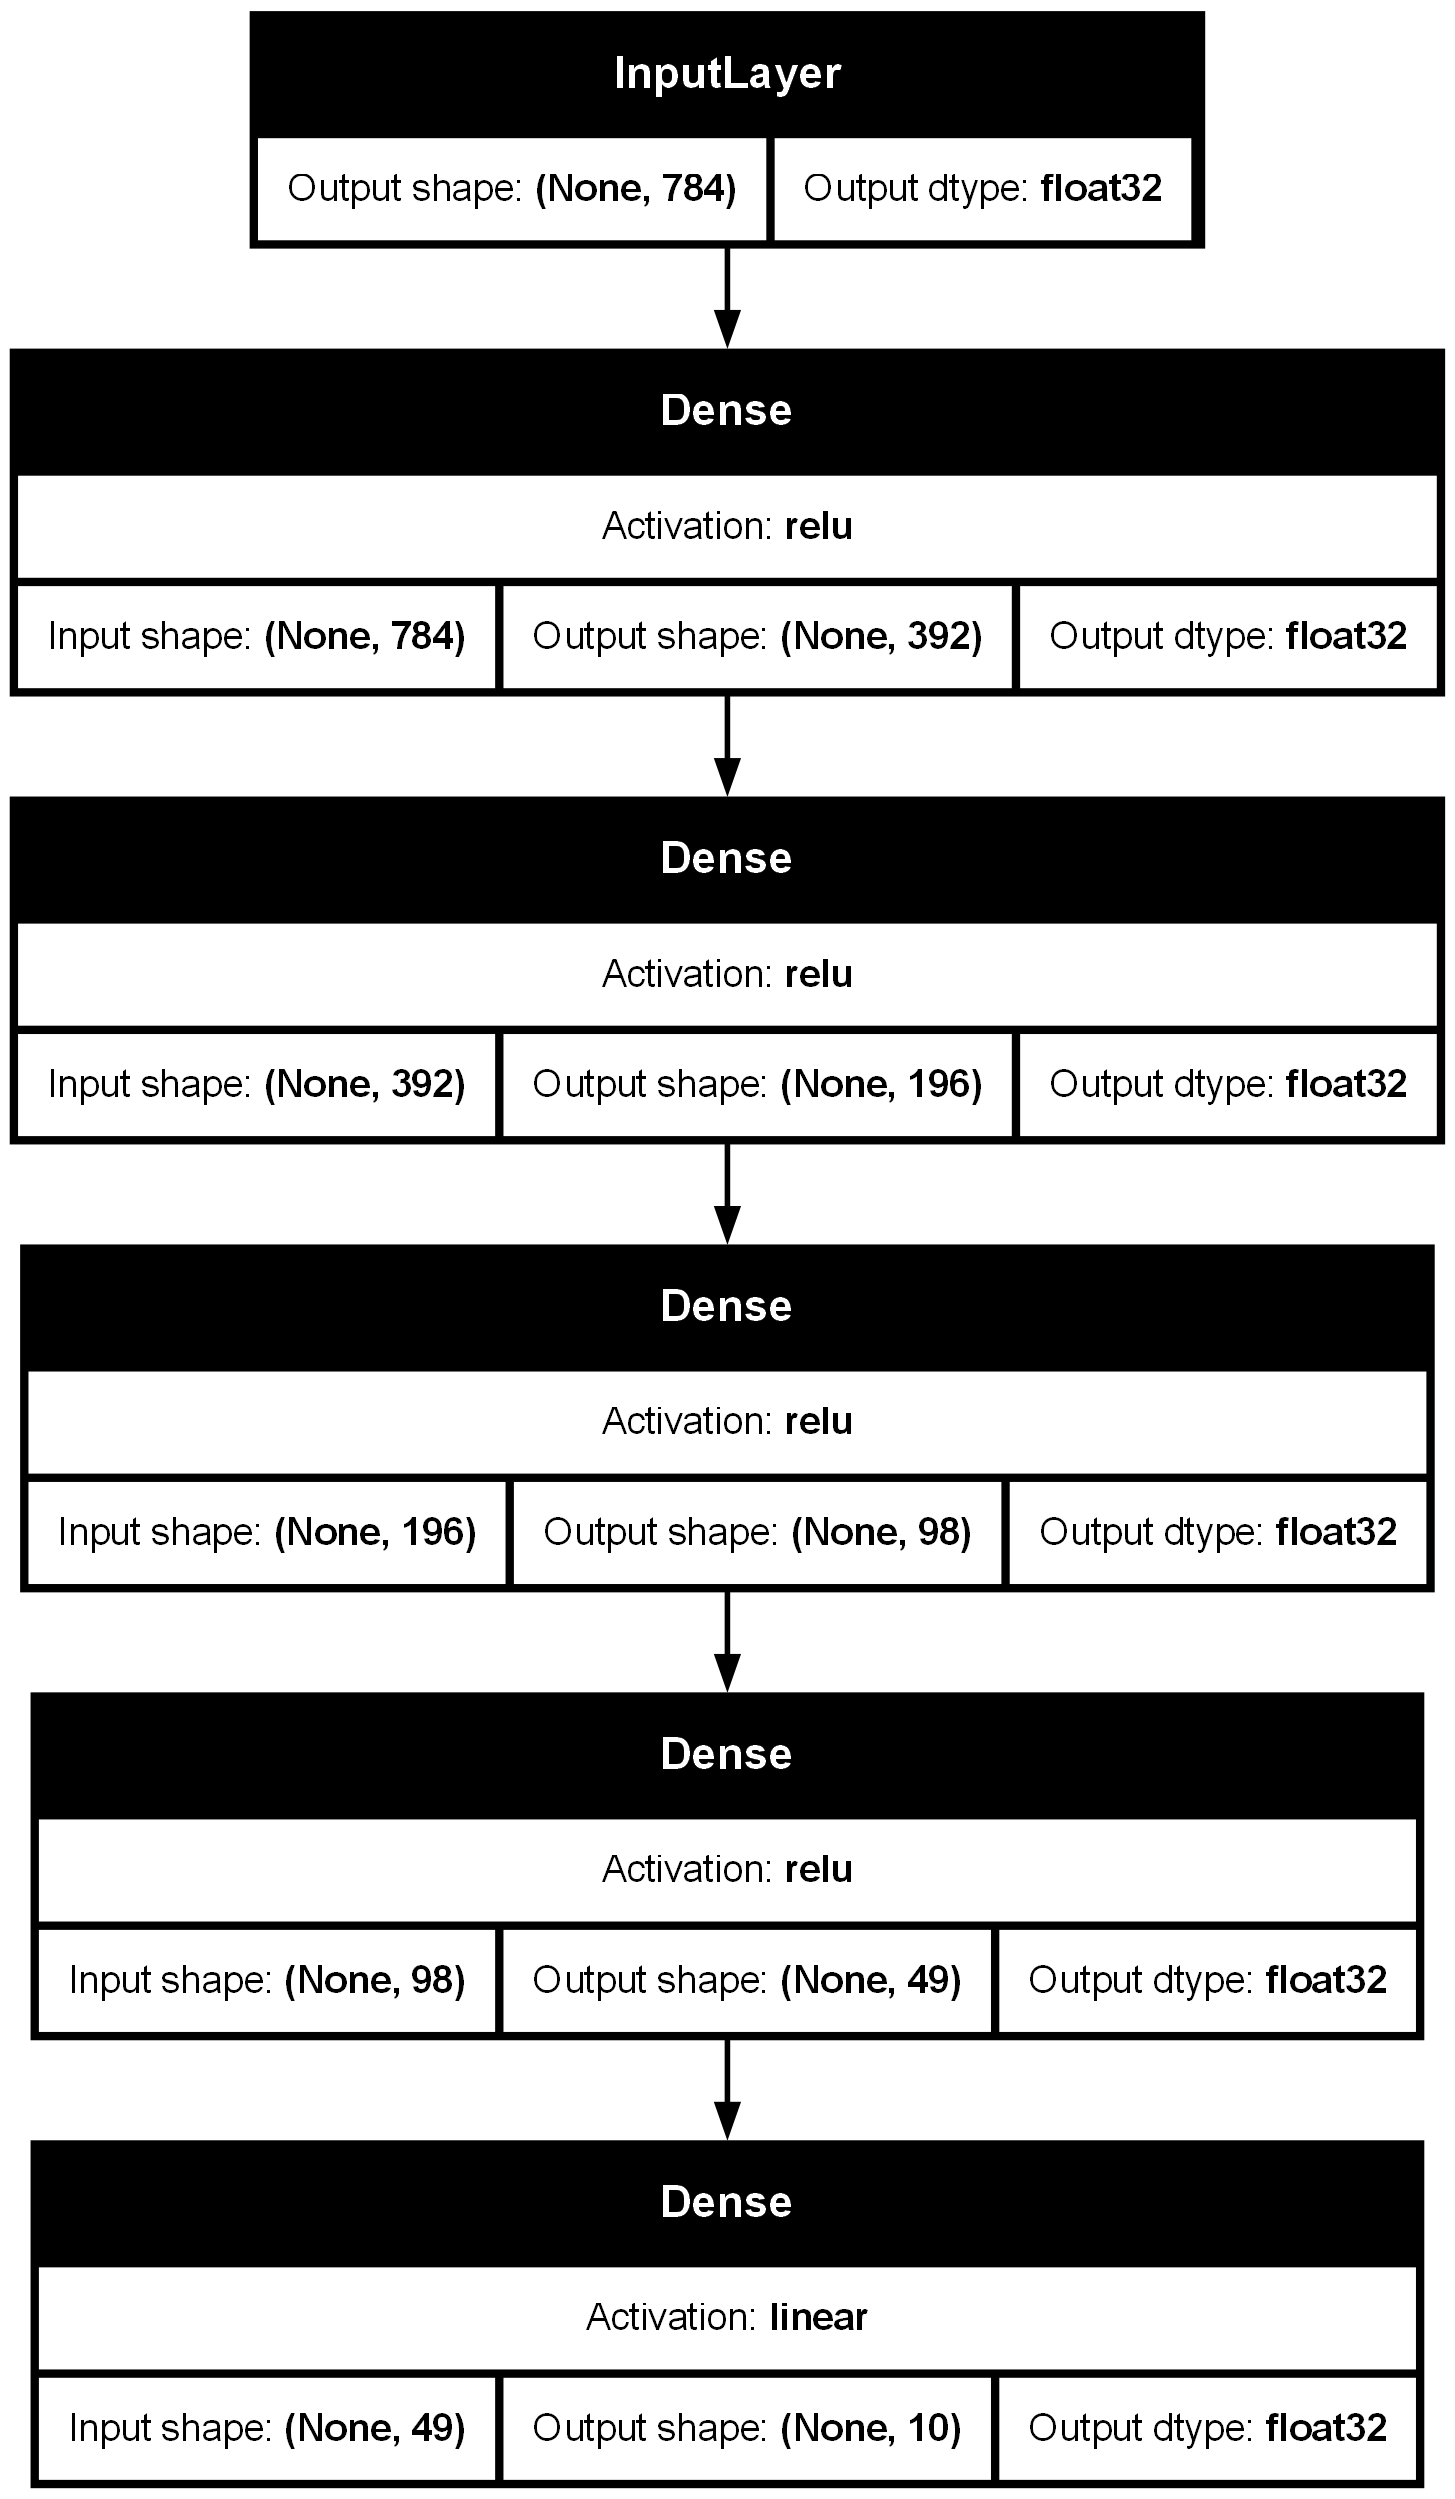

In [39]:
tf.keras.utils.plot_model(
    model, 
    os.path.join(outDir, 'mnist_dataset.png'),
    show_shapes=True, 
    show_dtype=True, 
    show_layer_activations=True
)

$$\text{
    Compiling the model
}
$$

In [40]:
# Optimized for model
optimizer = tf.keras.optimizers.Adam(learning_rate = ALPHA)


# Compile
model.compile(
    optimizer = optimizer,
    loss = loss_fn,
    metrics = ['accuracy']
)

$$\text{
    Fitting the model
}
$$

In [ ]:
history = model.fit(
    train_ds, 
    validation_data = test_ds,
    batch_size = BATCH_SIZE,
    verbose = 1,
    epochs =EPOCHS
)

Epoch 1/32
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.7597 - loss: 0.6774 - val_accuracy: 0.8596 - val_loss: 0.3955
Epoch 2/32
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8586 - loss: 0.3878 - val_accuracy: 0.8673 - val_loss: 0.3750
Epoch 3/32
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8740 - loss: 0.3430 - val_accuracy: 0.8712 - val_loss: 0.3556
Epoch 4/32
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8849 - loss: 0.3127 - val_accuracy: 0.8796 - val_loss: 0.3422
Epoch 5/32
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8900 - loss: 0.2974 - val_accuracy: 0.8813 - val_loss: 0.3312
Epoch 6/32
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8957 - loss: 0.2785 - val_accuracy: 0.8769 - val_loss: 0.3395
Epoch 7/32
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8998 - loss: 0.2679 - val_accuracy: 0.8787 - val_loss: 0.3379
Epoch 8/32
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9059 - loss: 0.2523 - 

$$\text{
    Getting history and Plotting Accuracy and Loss Graphs
}
$$

,accuracy,loss,val_accuracy,val_loss
0,0.811542,0.522770,0.859583,0.395481
1,0.860062,0.383957,0.867250,0.374974
2,0.873979,0.345002,0.871250,0.355573


,accuracy,loss,val_accuracy,val_loss
29,0.949812,0.130577,0.884000,0.499137
30,0.950000,0.129511,0.888667,0.491303
31,0.951458,0.126998,0.883833,0.546161


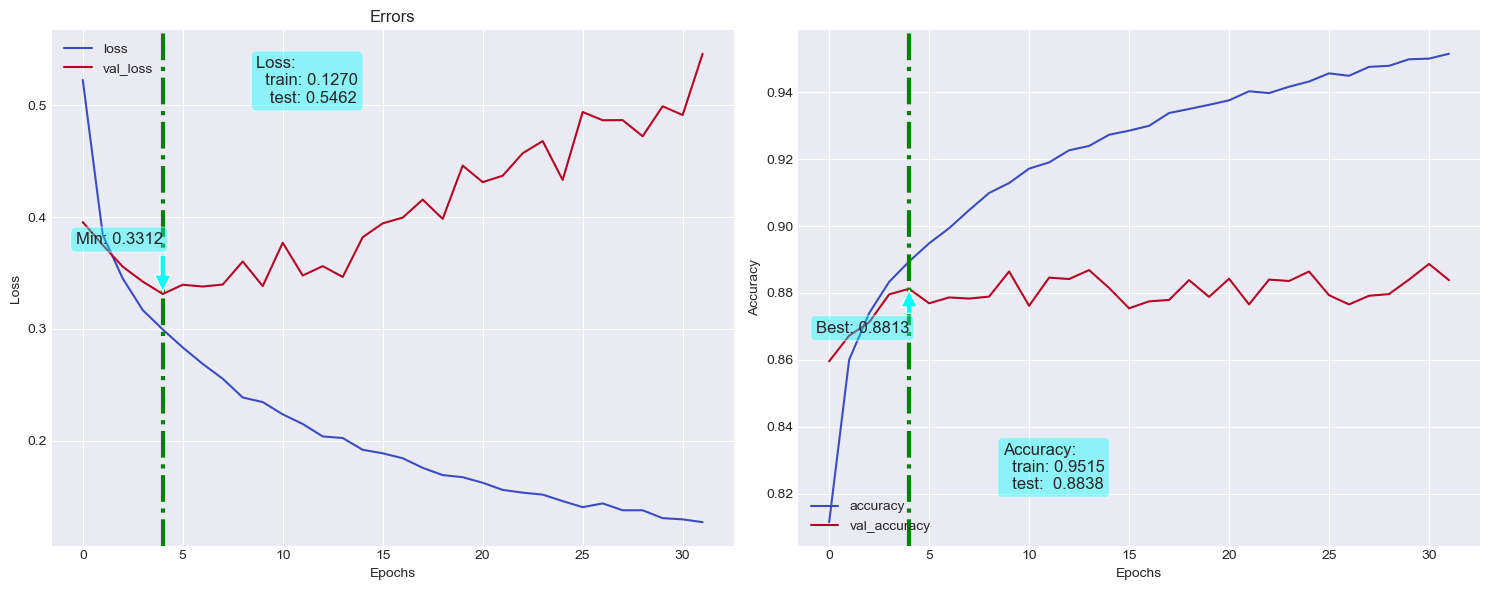

In [ ]:
hist_df = pd.DataFrame(history.history) 

display(hist_df.head(3))
display(hist_df.tail(3))

fn_plot_tf_hist(hist_df = hist_df)

$$\text{
Creating the Prediction Model
}
$$

In [44]:
prediction_model = tf.keras.Sequential([
    model,
    tf.keras.layers.Softmax()
])
prediction_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_1 (Functional)       │ (None, 10)             │       409,405 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Softmax)               │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 409,405 (1.56 MB)

 Trainable params: 409,405 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

Dataset Train
48000 48000
93.79375


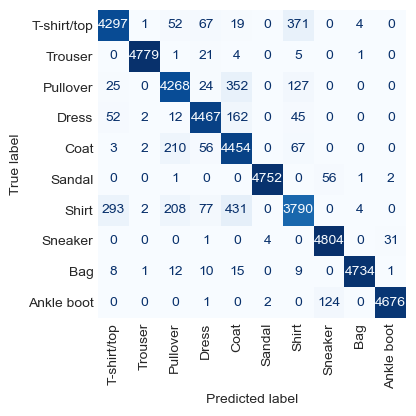

Dataset Test
12000 12000
88.38333333333334


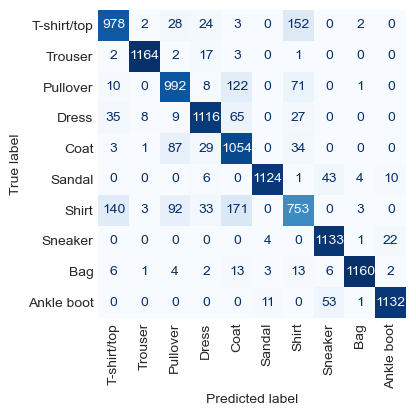

Dataset Validation
10000 10000
88.81


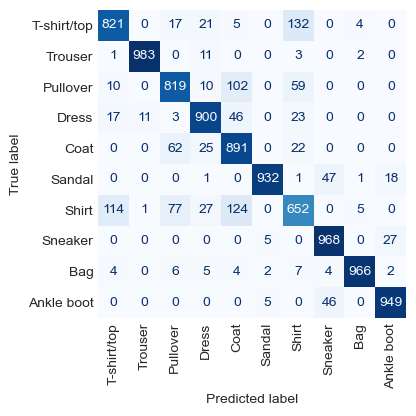

In [45]:
ds = {
    'Train' : train_ds,
    'Test' : test_ds,
    'Validation' : valid_ds
}

for name, data_ds in ds.items():
    print(f'Dataset {name}')
    accuracy_socre_confusion_matrix(data_ds=data_ds, prediction_model=prediction_model, labels=class_names.values())

---

$$\large\text{
    Model Initializer
}
$$

In [ ]:
# inintializer
initializer = tf.keras.initializers.GlorotUniform(seed=RANDOM_STATE)

# Input
inputs = tf.keras.Input(shape=(784,), name='input')


# Hidden Layer
x = tf.keras.layers.Dense(
    392, 
    kernel_initializer=initializer,
    activation=tf.keras.activations.relu, 
    name='fc_1'
)(inputs)
x = tf.keras.layers.Dense(
    196, 
    kernel_initializer=initializer,
    activation=tf.keras.activations.relu, 
    name='fc_2'
)(x)
x = tf.keras.layers.Dense(
    98, 
    kernel_initializer=initializer,
    activation=tf.keras.activations.relu, 
    name='fc_3'
)(x)
x = tf.keras.layers.Dense(
    49, 
    kernel_initializer=initializer,
    activation=tf.keras.activations.relu, 
    name='fc_4'
)(x)

# Output 
outputs = tf.keras.layers.Dense(
    out_len, 
    kernel_initializer=initializer,
    name='output'
)(x)

                                
# Model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_1 (Dense)                    │ (None, 392)            │       307,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_2 (Dense)                    │ (None, 196)            │        77,028 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_3 (Dense)                    │ (None, 98)             │        19,306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_4 (Dense)                    │ (None, 49)             │         4,851 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 409,405 (1.56 MB)

 Trainable params: 409,405 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

$$\text{
    Creating the loss function for the model
}
$$

In [48]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

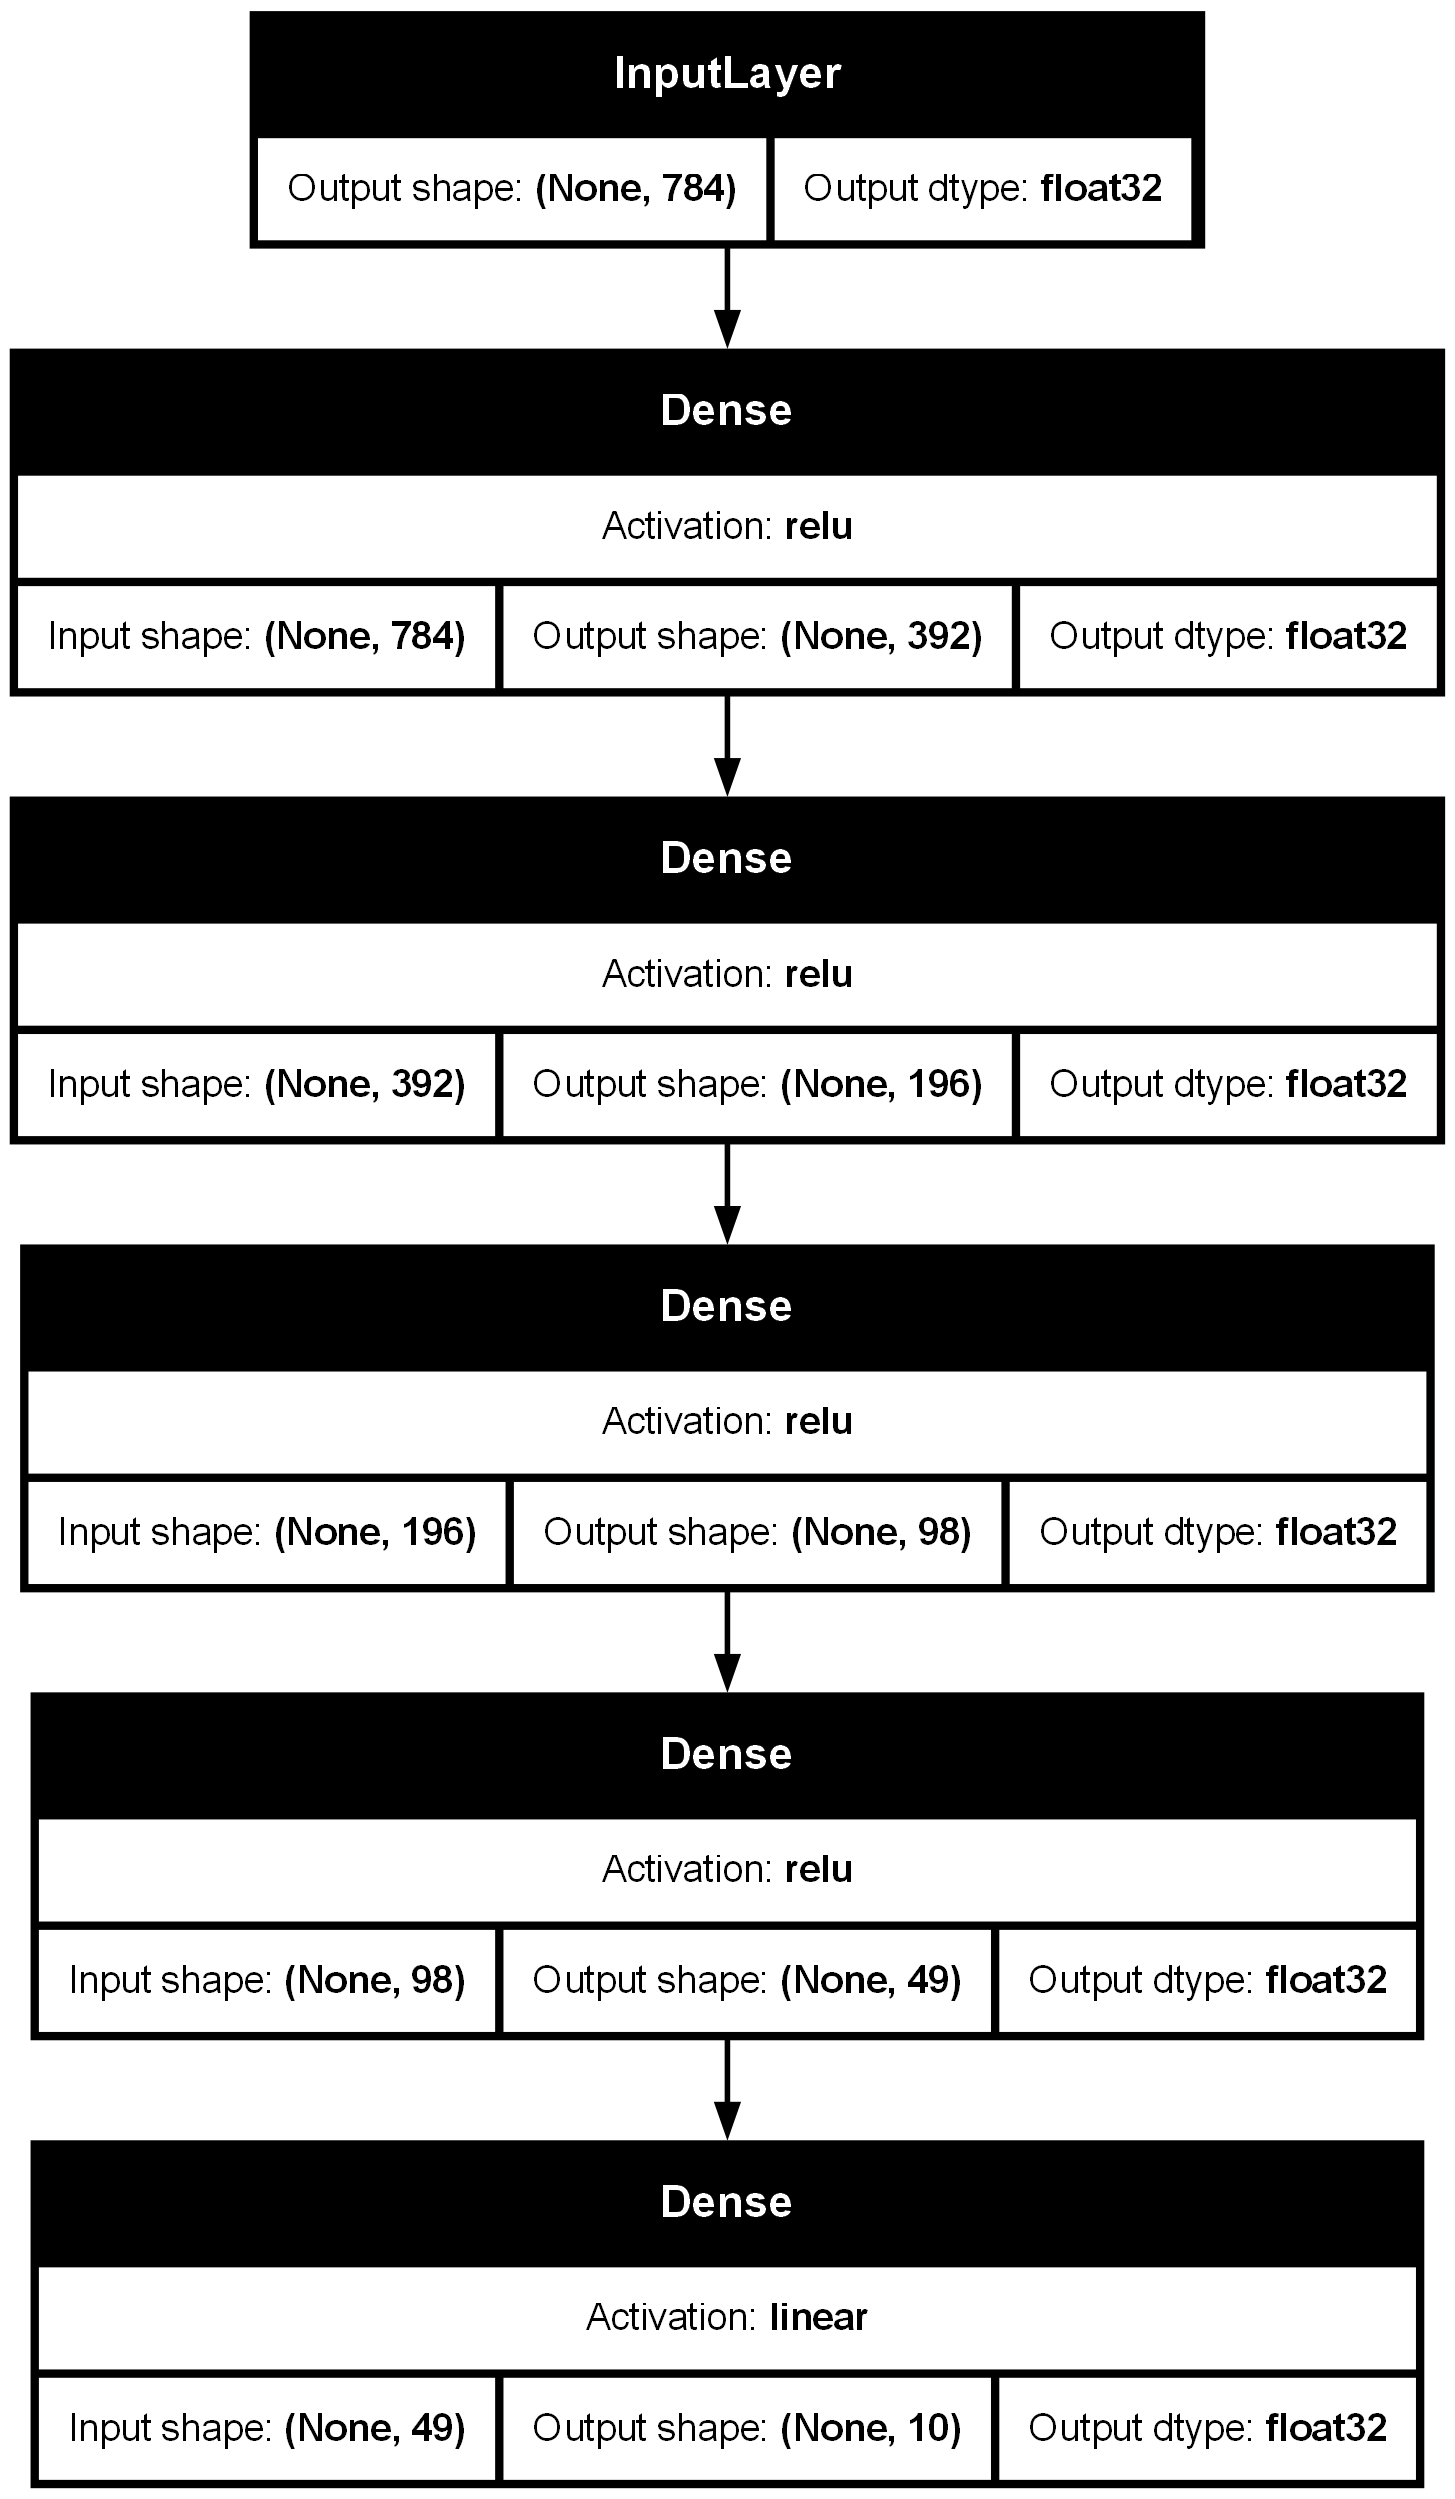

In [49]:
tf.keras.utils.plot_model(
    model, 
    os.path.join(outDir, 'mnist_dataset.png'),
    show_shapes=True, 
    show_dtype=True, 
    show_layer_activations=True
)

$$\text{
    Compiling the model
}
$$

In [50]:
# Optimized for model
optimizer = tf.keras.optimizers.Adam(learning_rate = ALPHA)

# Compile
model.compile(
    optimizer = optimizer,
    loss = loss_fn,
    metrics = ['accuracy']
)

$$\text{
    Fitting the model
}
$$

In [51]:
history = model.fit(
    train_ds, 
    validation_data = test_ds,
    batch_size = BATCH_SIZE,
    verbose = 1,
    epochs =EPOCHS
)

Epoch 1/32
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.7541 - loss: 0.6709 - val_accuracy: 0.8579 - val_loss: 0.3996
Epoch 2/32
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8574 - loss: 0.3904 - val_accuracy: 0.8662 - val_loss: 0.3754
Epoch 3/32
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8743 - loss: 0.3437 - val_accuracy: 0.8771 - val_loss: 0.3464
Epoch 4/32
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8837 - loss: 0.3184 - val_accuracy: 0.8783 - val_loss: 0.3381
Epoch 5/32
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8913 - loss: 0.2941 - val_accuracy: 0.8808 - val_loss: 0.3376
Epoch 6/32
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.8974 - loss: 0.2779 - val_accuracy: 0.8783 - val_loss: 0.3469
Epoch 7/32
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9031 - loss: 0.2635 - val_accuracy: 0.8850 - val_loss: 0.3334
Epoch 8/32
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9061 - loss: 0.2530 - 

$$\text{
    Getting history and Plotting Accuracy and Loss Graphs
}
$$

,accuracy,loss,val_accuracy,val_loss
0,0.810896,0.519571,0.857917,0.399640
1,0.859563,0.385612,0.866167,0.375425
2,0.873750,0.344766,0.877083,0.346449


,accuracy,loss,val_accuracy,val_loss
29,0.948667,0.132121,0.885250,0.488532
30,0.948625,0.132705,0.887333,0.432877
31,0.947792,0.138023,0.886667,0.509090


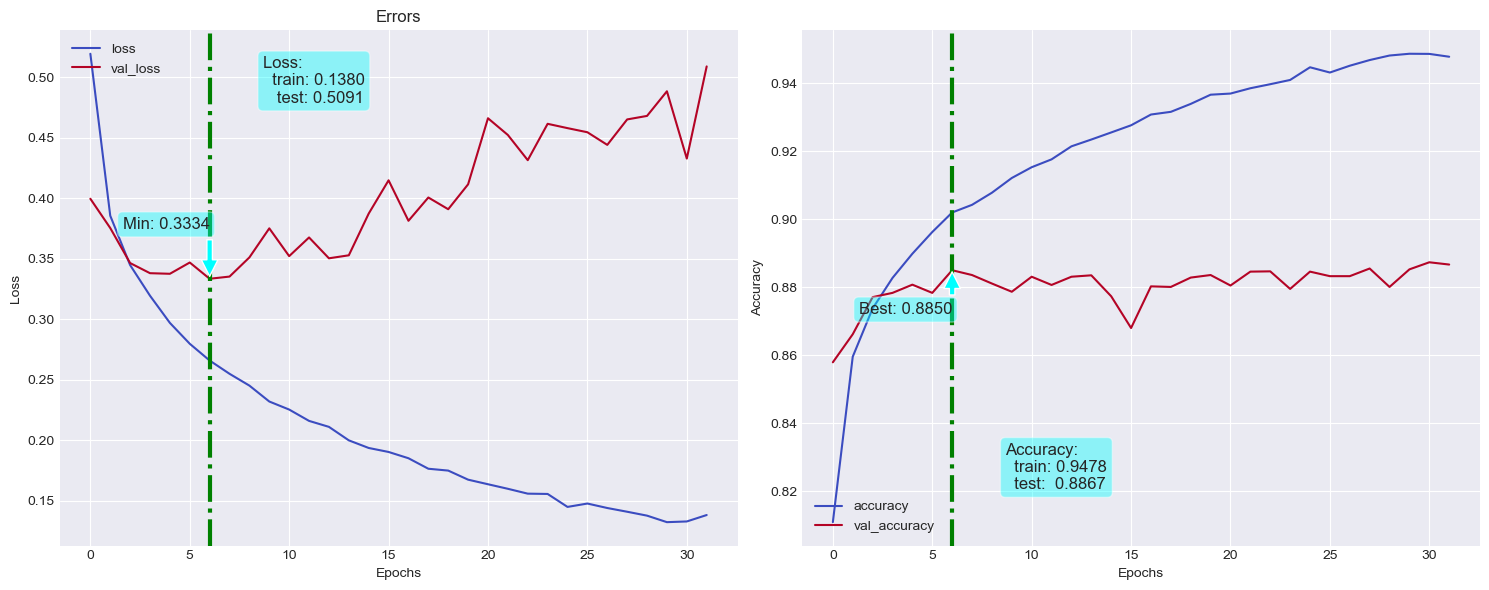

In [52]:
hist_df = pd.DataFrame(history.history) 

display(hist_df.head(3))
display(hist_df.tail(3))

fn_plot_tf_hist(hist_df = hist_df)

In [53]:
prediction_model = tf.keras.Sequential([
    model,
    tf.keras.layers.Softmax()
])
prediction_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_3 (Functional)       │ (None, 10)             │       409,405 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_1 (Softmax)             │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 409,405 (1.56 MB)

 Trainable params: 409,405 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

Dataset Train
48000 48000
94.25416666666668


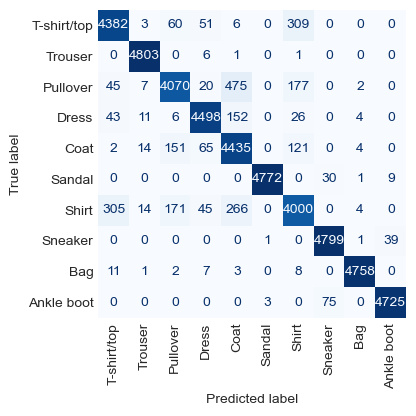

Dataset Test
12000 12000
88.66666666666667


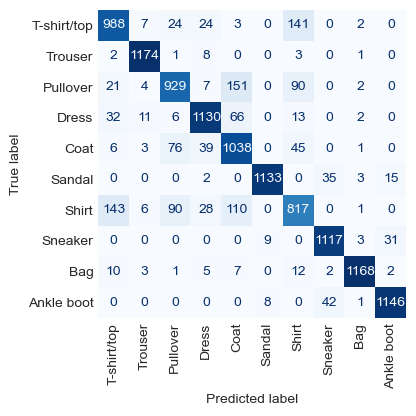

Dataset Validation
10000 10000
88.89


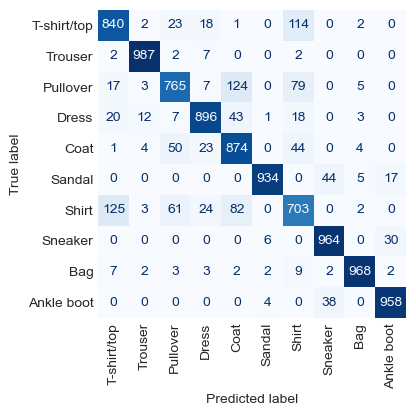

In [54]:
ds = {
    'Train' : train_ds,
    'Test' : test_ds,
    'Validation' : valid_ds
}

for name, data_ds in ds.items():
    print(f'Dataset {name}')
    accuracy_socre_confusion_matrix(data_ds=data_ds, prediction_model=prediction_model, labels=class_names.values())

---

$$\large\text{
    With Regularization
}$$

In [55]:
# inintializer
initializer = tf.keras.initializers.GlorotUniform(seed=RANDOM_STATE)

# regilarization
regularizer = tf.keras.regularizers.l2(l2=0.05) # l -> tune

# Input
inputs = tf.keras.Input(shape=(784,), name='input')


# Hidden Layer
x = tf.keras.layers.Dense(
    392, 
    kernel_initializer=initializer,
    kernel_regularizer=regularizer,
    activation=tf.keras.activations.relu, 
    name='fc_1'
)(inputs)
x = tf.keras.layers.Dense(
    196, 
    kernel_initializer=initializer,
    kernel_regularizer=regularizer,
    activation=tf.keras.activations.relu, 
    name='fc_2'
)(x)
x = tf.keras.layers.Dense(
    98, 
    kernel_initializer=initializer,
    kernel_regularizer=regularizer,
    activation=tf.keras.activations.relu, 
    name='fc_3'
)(x)
x = tf.keras.layers.Dense(
    49, 
    kernel_initializer=initializer,
    kernel_regularizer=regularizer,
    activation=tf.keras.activations.relu, 
    name='fc_4'
)(x)

# Output 
outputs = tf.keras.layers.Dense(
    out_len,
    kernel_initializer=initializer,
    kernel_regularizer=regularizer,
    activation=tf.keras.activations.softmax, 
    name='output'
)(x)
# Model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [56]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_1 (Dense)                    │ (None, 392)            │       307,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_2 (Dense)                    │ (None, 196)            │        77,028 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_3 (Dense)                    │ (None, 98)             │        19,306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_4 (Dense)                    │ (None, 49)             │         4,851 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 409,405 (1.56 MB)

 Trainable params: 409,405 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

$$\text{
    Creating the loss function for the model
}
$$

In [57]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

$$\text{
    Compiling the model
}
$$

In [58]:
# Optimized for model
optimizer = tf.keras.optimizers.Adam(learning_rate = ALPHA)

# Compile
model.compile(
    optimizer = optimizer,
    loss = loss_fn,
    metrics = ['accuracy']
)

$$\text{
    Fitting the model
}
$$

In [59]:
history = model.fit(
    train_ds, 
    validation_data = test_ds,
    batch_size = BATCH_SIZE,
    verbose = 1,
    epochs =EPOCHS
)

Epoch 1/32


c:\Users\DAI.STUDENTSDC\.conda\envs\pythonProject\Lib\site-packages\keras\src\backend\tensorflow\nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.5284 - loss: 6.6989 - val_accuracy: 0.6022 - val_loss: 1.9322
Epoch 2/32
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6028 - loss: 1.9106 - val_accuracy: 0.6263 - val_loss: 1.8807
Epoch 3/32
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6112 - loss: 1.8761 - val_accuracy: 0.6324 - val_loss: 1.8551
Epoch 4/32
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6135 - loss: 1.8514 - val_accuracy: 0.6338 - val_loss: 1.8341
Epoch 5/32
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6164 - loss: 1.8327 - val_accuracy: 0.6376 - val_loss: 1.8205
Epoch 6/32
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.6190 - loss: 1.8201 - val_accuracy: 0.6378 - val_loss: 1.8113
Epoch 7/32
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6206 - loss: 1.8110 - val_accuracy: 0.6342 - val_loss: 1.8003
Epoch 8/32
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6220 - loss: 1.8038 - val_accura

$$\text{
    Getting history and Plotting Accuracy and Loss Graphs
}
$$

,accuracy,loss,val_accuracy,val_loss
0,0.562958,3.074023,0.602167,1.932171
1,0.603583,1.904060,0.626333,1.880694
2,0.610563,1.872249,0.632417,1.855119


,accuracy,loss,val_accuracy,val_loss
29,0.628646,1.774751,0.64175,1.774296
30,0.628896,1.774305,0.64150,1.774666
31,0.629188,1.773799,0.64250,1.774125


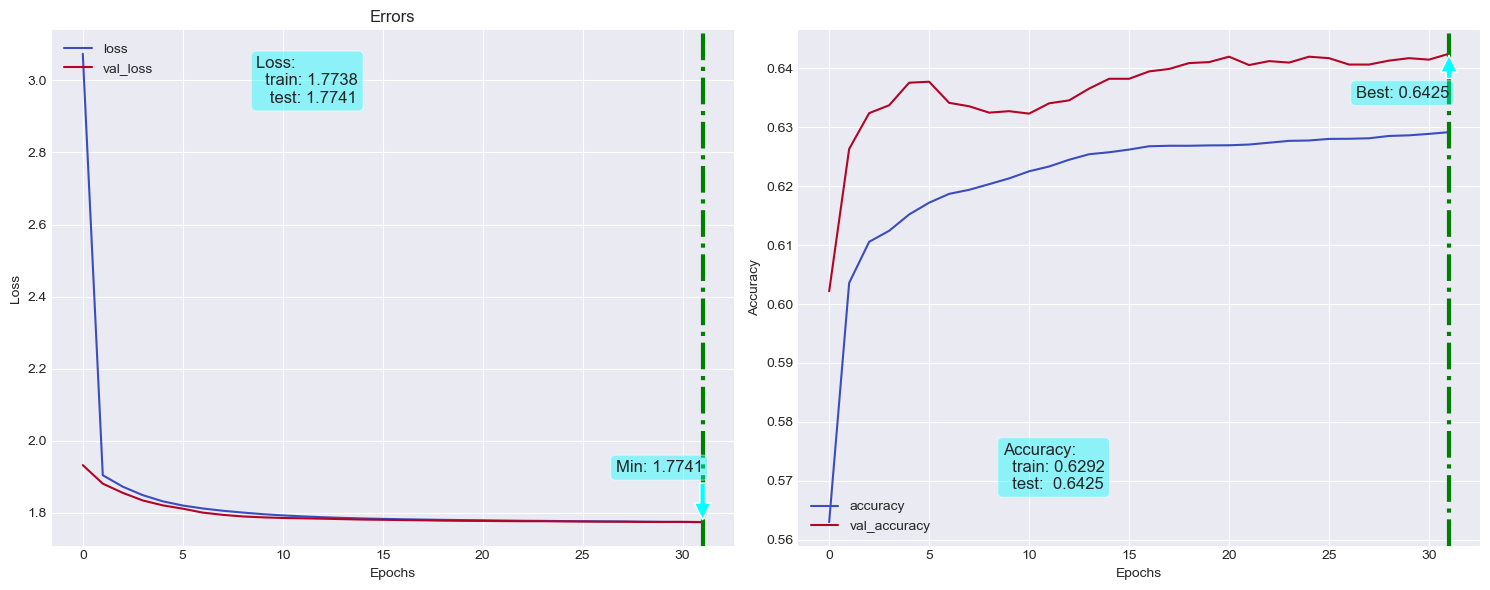

In [60]:
hist_df = pd.DataFrame(history.history) 

display(hist_df.head(3))
display(hist_df.tail(3))

fn_plot_tf_hist(hist_df = hist_df)

$$\text{
Creating the Prediction Model
}
$$

In [61]:
prediction_model = tf.keras.Sequential([
    model,
    tf.keras.layers.Softmax()
])
prediction_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_5 (Functional)       │ (None, 10)             │       409,405 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_2 (Softmax)             │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 409,405 (1.56 MB)

 Trainable params: 409,405 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

$$
\text{
Accuracy and Confusion Matrix
}
$$

Dataset Train
48000 48000
64.9375


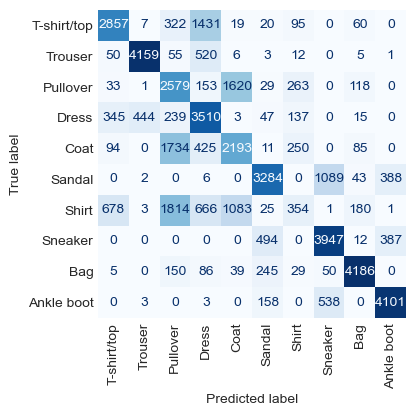

Dataset Test
12000 12000
64.25


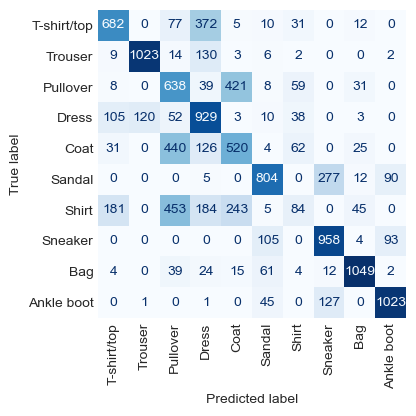

Dataset Validation
10000 10000
65.09


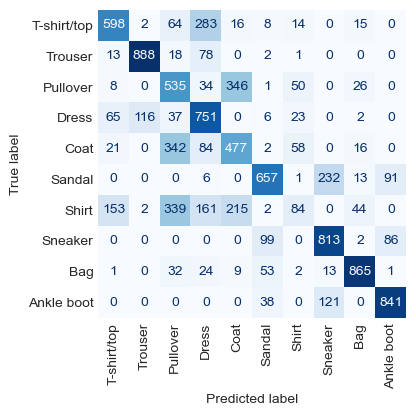

In [62]:
ds = {
    'Train' : train_ds,
    'Test' : test_ds,
    'Validation' : valid_ds
}

for name, data_ds in ds.items():
    print(f'Dataset {name}')
    accuracy_socre_confusion_matrix(data_ds=data_ds, prediction_model=prediction_model, labels=class_names.values())

---

$$\large\text{Batch Normalization}$$


In [63]:
# clear memory
del model
gc.collect()
gc.collect()

# inintializer
initializer = tf.keras.initializers.GlorotUniform(seed=RANDOM_STATE)

# Input
inputs = tf.keras.Input(shape=(784,), name='input')



# Set 1st Hidden Layer
x = tf.keras.layers.Dense(
    392, 
    kernel_initializer=initializer,
    name='fc_1'
)(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation(activation=tf.keras.activations.relu)(x)

# Set 2nd Hidden Layer
x = tf.keras.layers.Dense(
    196, 
    kernel_initializer=initializer,
    name='fc_2'
)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation(activation=tf.keras.activations.relu)(x)

# Set 3rd Hidden Layer
x = tf.keras.layers.Dense(
    98, 
    kernel_initializer=initializer,
    name='fc_3'
)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation(activation=tf.keras.activations.relu)(x)

# Set 4th Hidden Layer
x = tf.keras.layers.Dense(
    49, 
    kernel_initializer=initializer,
    name='fc_4'
)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation(activation=tf.keras.activations.relu)(x)

# Output 
outputs = tf.keras.layers.Dense(
    out_len, 
    kernel_initializer=initializer,
    name='output'
)(x)

# Model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [64]:
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_1 (Dense)                    │ (None, 392)            │       307,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 392)            │         1,568 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 392)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_2 (Dense)                    │ (None, 196)            │        77,028 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 196)            │           784 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 196)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_3 (Dense)                    │ (None, 98)             │        19,306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 98)             │           392 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 98)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_4 (Dense)                    │ (None, 49)             │         4,851 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 49)             │           196 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 49)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 412,345 (1.57 MB)

 Trainable params: 410,875 (1.57 MB)

 Non-trainable params: 1,470 (5.74 KB)

$$\text{
    Creating the loss function for the model
}
$$

In [65]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

$$\text{
    Compiling the model
}
$$

In [66]:
# Optimized for model
optimizer = tf.keras.optimizers.Adam(learning_rate = ALPHA)

# Compile
model.compile(
    optimizer = optimizer,
    loss = loss_fn,
    metrics = ['accuracy']
)

$$\text{
    Fitting the model
}
$$

In [67]:
history = model.fit(
    train_ds, 
    validation_data = test_ds,
    batch_size = BATCH_SIZE,
    verbose = 1,
    epochs =EPOCHS
)

Epoch 1/32
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.7810 - loss: 0.6608 - val_accuracy: 0.8501 - val_loss: 0.4041
Epoch 2/32
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.8598 - loss: 0.3874 - val_accuracy: 0.8572 - val_loss: 0.3906
Epoch 3/32
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8798 - loss: 0.3308 - val_accuracy: 0.8676 - val_loss: 0.3662
Epoch 4/32
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8937 - loss: 0.2907 - val_accuracy: 0.8550 - val_loss: 0.4025
Epoch 5/32
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9073 - loss: 0.2580 - val_accuracy: 0.8625 - val_loss: 0.3978
Epoch 6/32
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9172 - loss: 0.2294 - val_accuracy: 0.8665 - val_loss: 0.3876
Epoch 7/32
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9263 - loss: 0.2058 - val_accuracy: 0.8339 - val_loss: 0.5085
Epoch 8/32
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9349 - loss: 0.

$$\text{
    Getting history and Plotting Accuracy and Loss Graphs
}
$$

,accuracy,loss,val_accuracy,val_loss
0,0.817021,0.526071,0.850083,0.404063
1,0.860417,0.382919,0.857167,0.390587
2,0.880125,0.329188,0.867583,0.366174


,accuracy,loss,val_accuracy,val_loss
29,0.987521,0.034960,0.870500,0.715134
30,0.986125,0.039171,0.871250,0.751148
31,0.986292,0.037958,0.882667,0.687526


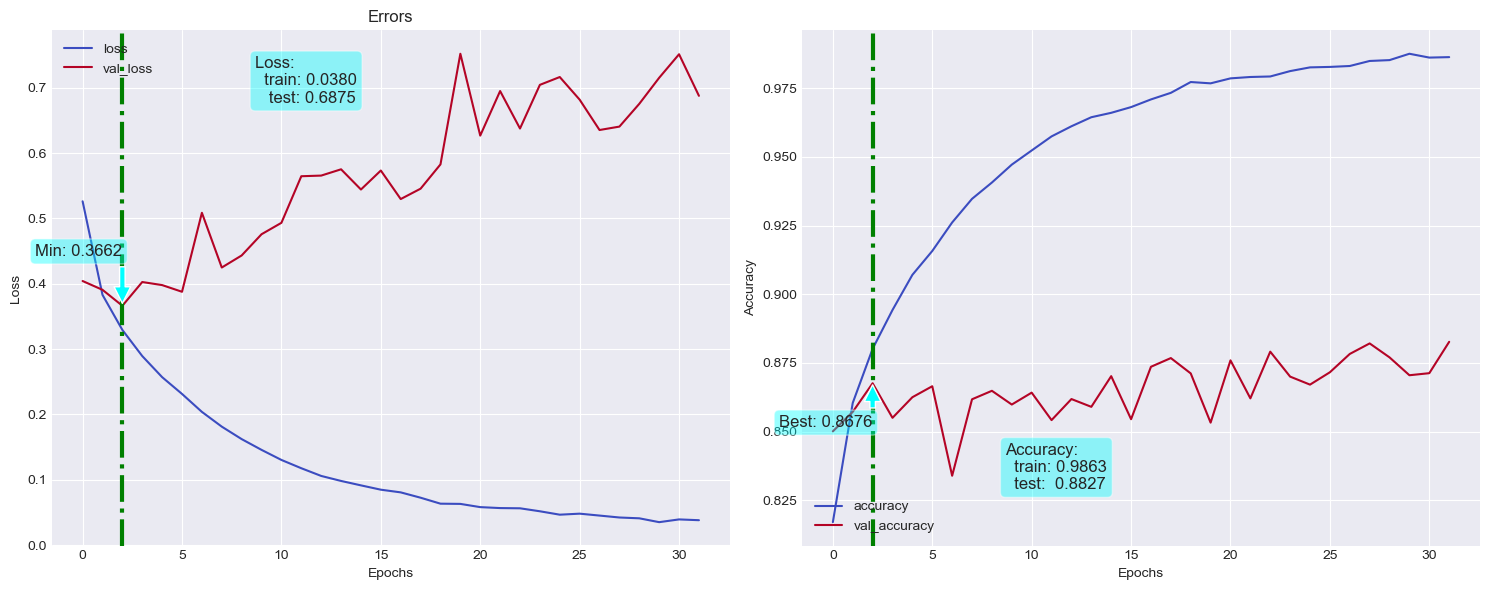

In [68]:
hist_df = pd.DataFrame(history.history) 

display(hist_df.head(3))
display(hist_df.tail(3))

fn_plot_tf_hist(hist_df = hist_df)

$$\text{
Creating the Prediction Model
}
$$

In [69]:
prediction_model = tf.keras.Sequential([
    model,
    tf.keras.layers.Softmax()
])
prediction_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_7 (Functional)       │ (None, 10)             │       412,345 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_3 (Softmax)             │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 412,345 (1.57 MB)

 Trainable params: 410,875 (1.57 MB)

 Non-trainable params: 1,470 (5.74 KB)

$$
\text{
Accuracy and Confusion Matrix
}
$$

Dataset Train
48000 48000
94.4625


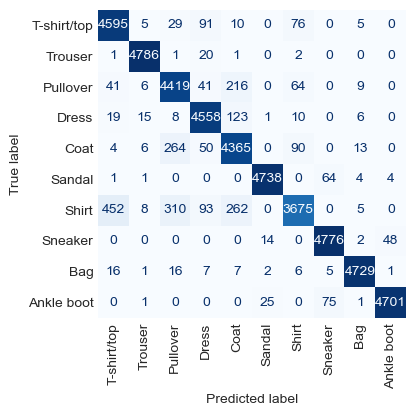

Dataset Test
12000 12000
88.26666666666667


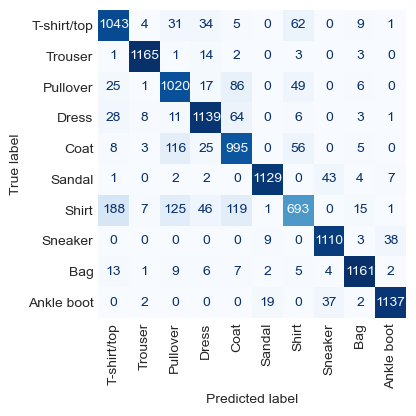

Dataset Validation
10000 10000
88.92


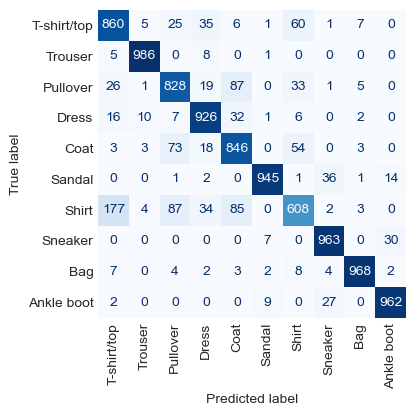

In [70]:
ds = {
    'Train' : train_ds,
    'Test' : test_ds,
    'Validation' : valid_ds
}

for name, data_ds in ds.items():
    print(f'Dataset {name}')
    accuracy_socre_confusion_matrix(data_ds=data_ds, prediction_model=prediction_model, labels=class_names.values())

---


$$\large\text{
    Model with Dropout
}$$

In [71]:
drops = [
    [0.3,0.3,0.3,0.3,0.3],
    [0.2,0.3,0.4,0.5,0.6],
    [0.6,0.5,0.4,0.3,0.2]
]

DOR1, DOR2, DOR3, DOR4, DOR5 = drops[1] # Best

# clear memory
del model
gc.collect()
gc.collect()

# inintializer
initializer = tf.keras.initializers.GlorotUniform(seed=RANDOM_STATE)

# Input
inputs = tf.keras.Input(shape=(784,), name='input')


# Set 1st Hidden Layer
x = tf.keras.layers.Dense(
    392, 
    kernel_initializer=initializer,
    name='fc_1'
)(inputs)
x = tf.keras.layers.Activation(activation=tf.keras.activations.relu)(x)
x = tf.keras.layers.Dropout(rate=DOR1)(x)

# Set 2nd Hidden Layer
x = tf.keras.layers.Dense(
    196, 
    kernel_initializer=initializer,
    name='fc_2'
)(x)
x = tf.keras.layers.Activation(activation=tf.keras.activations.relu)(x)
x = tf.keras.layers.Dropout(rate=DOR2)(x)

# Set 3rd Hidden Layer
x = tf.keras.layers.Dense(
    98, 
    kernel_initializer=initializer,
    name='fc_3'
)(x)
x = tf.keras.layers.Activation(activation=tf.keras.activations.relu)(x)
x = tf.keras.layers.Dropout(rate=DOR3)(x)

# Set 4th Hidden Layer
x = tf.keras.layers.Dense(
    49, 
    kernel_initializer=initializer,
    name='fc_4'
)(x)
x = tf.keras.layers.Activation(activation=tf.keras.activations.relu)(x)
x = tf.keras.layers.Dropout(rate=DOR4)(x)

# Output 
outputs = tf.keras.layers.Dense(
    out_len, 
    kernel_initializer=initializer,
    name='output'
)(x)

# Model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [72]:
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_1 (Dense)                    │ (None, 392)            │       307,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 392)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 392)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_2 (Dense)                    │ (None, 196)            │        77,028 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 196)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 196)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_3 (Dense)                    │ (None, 98)             │        19,306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 98)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 98)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_4 (Dense)                    │ (None, 49)             │         4,851 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 49)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 49)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 409,405 (1.56 MB)

 Trainable params: 409,405 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

$$\text{
    Creating the loss function for the model
}
$$

In [73]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

$$\text{
    Compiling the model
}
$$

In [74]:
# Optimized for model
optimizer = tf.keras.optimizers.Adam(learning_rate = ALPHA)

# Compile
model.compile(
    optimizer = optimizer,
    loss = loss_fn,
    metrics = ['accuracy']
)

$$\text{
    Fitting the model
}
$$

In [75]:
history = model.fit(
    train_ds, 
    validation_data = test_ds,
    batch_size = BATCH_SIZE,
    verbose = 1,
    epochs =EPOCHS
)

Epoch 1/32
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.5708 - loss: 1.1733 - val_accuracy: 0.8312 - val_loss: 0.4811
Epoch 2/32
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8027 - loss: 0.5805 - val_accuracy: 0.8468 - val_loss: 0.4331
Epoch 3/32
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8251 - loss: 0.5239 - val_accuracy: 0.8592 - val_loss: 0.4053
Epoch 4/32
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8381 - loss: 0.4814 - val_accuracy: 0.8422 - val_loss: 0.4238
Epoch 5/32
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8428 - loss: 0.4605 - val_accuracy: 0.8614 - val_loss: 0.3949
Epoch 6/32
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8528 - loss: 0.4404 - val_accuracy: 0.8694 - val_loss: 0.3761
Epoch 7/32
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8576 - loss: 0.4220 - val_accuracy: 0.8698 - val_loss: 0.3726
Epoch 8/32
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8579 - loss: 0.4108 -

$$\text{
    Getting history and Plotting Accuracy and Loss Graphs
}
$$

,accuracy,loss,val_accuracy,val_loss
0,0.692396,0.861145,0.831167,0.481099
1,0.806729,0.572349,0.846833,0.433147
2,0.825333,0.521817,0.859167,0.405347


,accuracy,loss,val_accuracy,val_loss
29,0.888458,0.331428,0.886667,0.361150
30,0.890688,0.320394,0.880750,0.378460
31,0.889083,0.322307,0.883917,0.363916


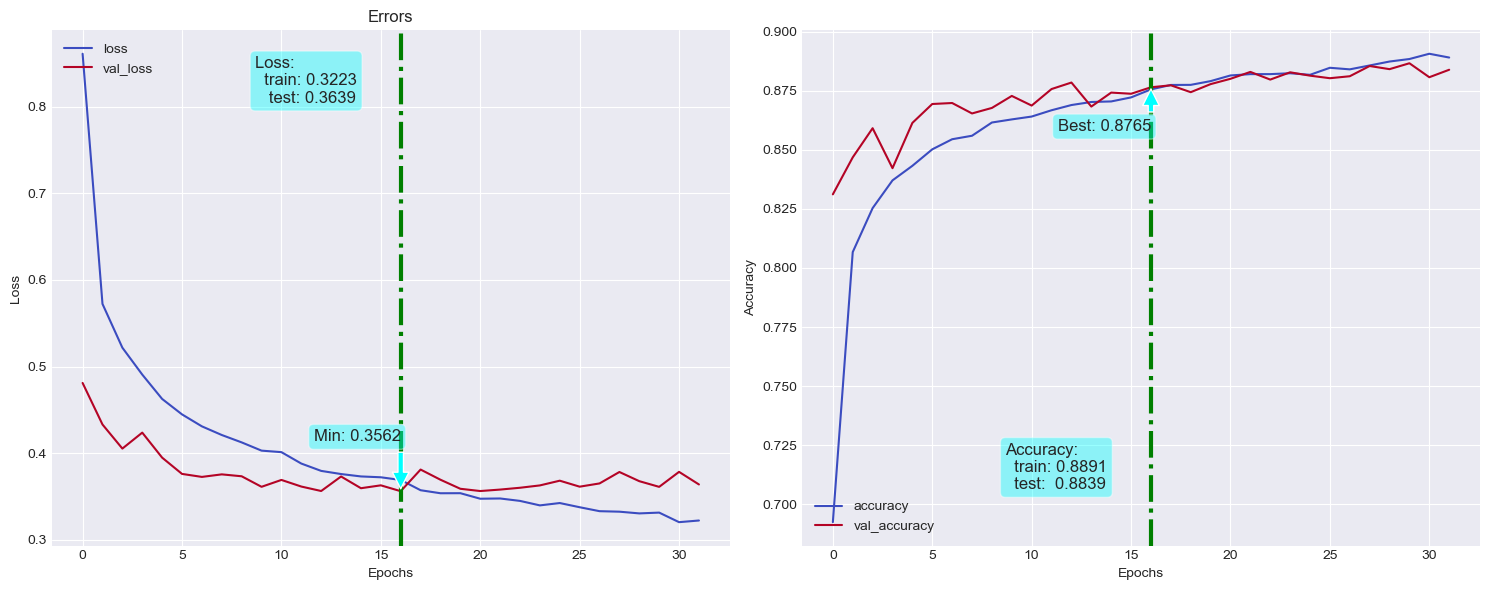

In [76]:
hist_df = pd.DataFrame(history.history) 

display(hist_df.head(3))
display(hist_df.tail(3))

fn_plot_tf_hist(hist_df = hist_df)

$$\text{
Creating the Prediction Model
}
$$

In [77]:
prediction_model = tf.keras.Sequential([
    model,
    tf.keras.layers.Softmax()
])
prediction_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_9 (Functional)       │ (None, 10)             │       409,405 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_4 (Softmax)             │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 409,405 (1.56 MB)

 Trainable params: 409,405 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

$$
\text{
Accuracy and Confusion Matrix
}
$$

Dataset Train
48000 48000
91.14166666666667


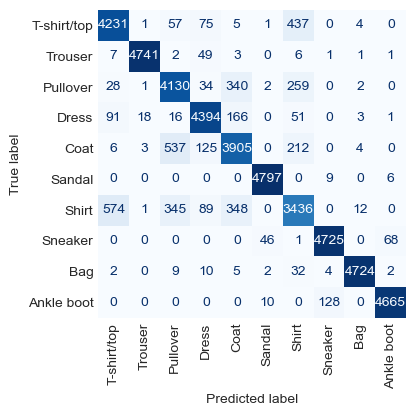

Dataset Test
12000 12000
88.39166666666667


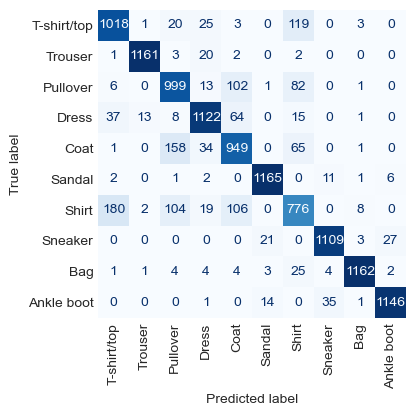

Dataset Validation
10000 10000
88.63


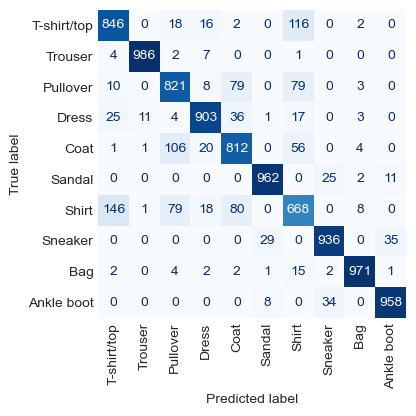

In [78]:
ds = {
    'Train' : train_ds,
    'Test' : test_ds,
    'Validation' : valid_ds
}

for name, data_ds in ds.items():
    print(f'Dataset {name}')
    accuracy_socre_confusion_matrix(data_ds=data_ds, prediction_model=prediction_model, labels=class_names.values())

---


$$\Large\text{
    Model with Dropout and Early Stopping
}$$

In [79]:
drops = [
    [0.3,0.3,0.3,0.3,0.3],
    [0.2,0.3,0.4,0.5,0.6],
    [0.6,0.5,0.4,0.3,0.2]
]

DOR1, DOR2, DOR3, DOR4, DOR5 = drops[1] # Best

# clear memory
del model
gc.collect()
gc.collect()

# inintializer
initializer = tf.keras.initializers.GlorotUniform(seed=RANDOM_STATE)

# Input
inputs = tf.keras.Input(shape=(784,), name='input')


# Set 1st Hidden Layer
x = tf.keras.layers.Dense(
    392, 
    kernel_initializer=initializer,
    name='fc_1'
)(inputs)
x = tf.keras.layers.Activation(activation=tf.keras.activations.relu)(x)
x = tf.keras.layers.Dropout(rate=DOR1)(x)

# Set 2nd Hidden Layer
x = tf.keras.layers.Dense(
    196, 
    kernel_initializer=initializer,
    name='fc_2'
)(x)
x = tf.keras.layers.Activation(activation=tf.keras.activations.relu)(x)
x = tf.keras.layers.Dropout(rate=DOR2)(x)

# Set 3rd Hidden Layer
x = tf.keras.layers.Dense(
    98, 
    kernel_initializer=initializer,
    name='fc_3'
)(x)
x = tf.keras.layers.Activation(activation=tf.keras.activations.relu)(x)
x = tf.keras.layers.Dropout(rate=DOR3)(x)

# Set 4th Hidden Layer
x = tf.keras.layers.Dense(
    49, 
    kernel_initializer=initializer,
    name='fc_4'
)(x)
x = tf.keras.layers.Activation(activation=tf.keras.activations.relu)(x)
x = tf.keras.layers.Dropout(rate=DOR4)(x)

# Output 
outputs = tf.keras.layers.Dense(
    out_len, 
    kernel_initializer=initializer,
    name='output'
)(x)

# Model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [80]:
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_1 (Dense)                    │ (None, 392)            │       307,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 392)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 392)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_2 (Dense)                    │ (None, 196)            │        77,028 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 196)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 196)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_3 (Dense)                    │ (None, 98)             │        19,306 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 98)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 98)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_4 (Dense)                    │ (None, 49)             │         4,851 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 49)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 49)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │           500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 409,405 (1.56 MB)

 Trainable params: 409,405 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

$$\text{
    Creating the loss function for the model
}
$$

In [81]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

$$\text{
    Fitting the model
}
$$

In [85]:
chkptPath = os.path.join(modelDir, subDir, 'all_in.keras')

checpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    chkptPath,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=PATIENCE,
    verbose=1, 
    restore_best_weights=True
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=LR_FACTOR,
    patience=LR_PATIENCE,
    verbose=1,
)

$$\text{
    Compiling the model
}
$$

In [86]:
# Optimized for model
optimizer = tf.keras.optimizers.Adam(learning_rate = ALPHA)

# Compile
model.compile(
    optimizer = optimizer,
    loss = loss_fn,
    metrics = ['accuracy']
)

$$\text{
    Fitting the model
}
$$

In [87]:
history = model.fit(
    train_ds, 
    validation_data = test_ds,
    batch_size = BATCH_SIZE,
    verbose = 1,
    epochs =EPOCHS,
    callbacks = [
        checpoint_cb,
        early_stopping_cb,
        lr_scheduler
    ]
)

Epoch 1/20
1496/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5607 - loss: 1.1893
Epoch 1: val_loss improved from inf to 0.51093, saving model to ../models\mnist_fashion\all_in.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.5611 - loss: 1.1883 - val_accuracy: 0.8046 - val_loss: 0.5109 - learning_rate: 0.0010
Epoch 2/20
1499/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7891 - loss: 0.6039
Epoch 2: val_loss improved from 0.51093 to 0.43654, saving model to ../models\mnist_fashion\all_in.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.7891 - loss: 0.6038 - val_accuracy: 0.8379 - val_loss: 0.4365 - learning_rate: 0.0010
Epoch 3/20
1495/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8241 - loss: 0.5206
Epoch 3: val_loss improved from 0.43654 to 0.40529, saving model to ../models\mnist_fashion\all_in.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.8241 - loss: 0.5206 - val_accuracy: 0.8511 - val_loss: 0.4053 - learning_rate: 0.

$$\text{
    Getting history and Plotting Accuracy and Loss Graphs
}
$$

,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.679021,0.880445,0.804583,0.510933,0.001
1,0.796542,0.588272,0.837917,0.436539,0.001
2,0.824000,0.523071,0.851083,0.405291,0.001


,accuracy,loss,val_accuracy,val_loss,learning_rate
17,0.876771,0.358043,0.882667,0.354531,0.001
18,0.877500,0.358389,0.869833,0.387722,0.001
19,0.880875,0.347163,0.873500,0.377715,0.001


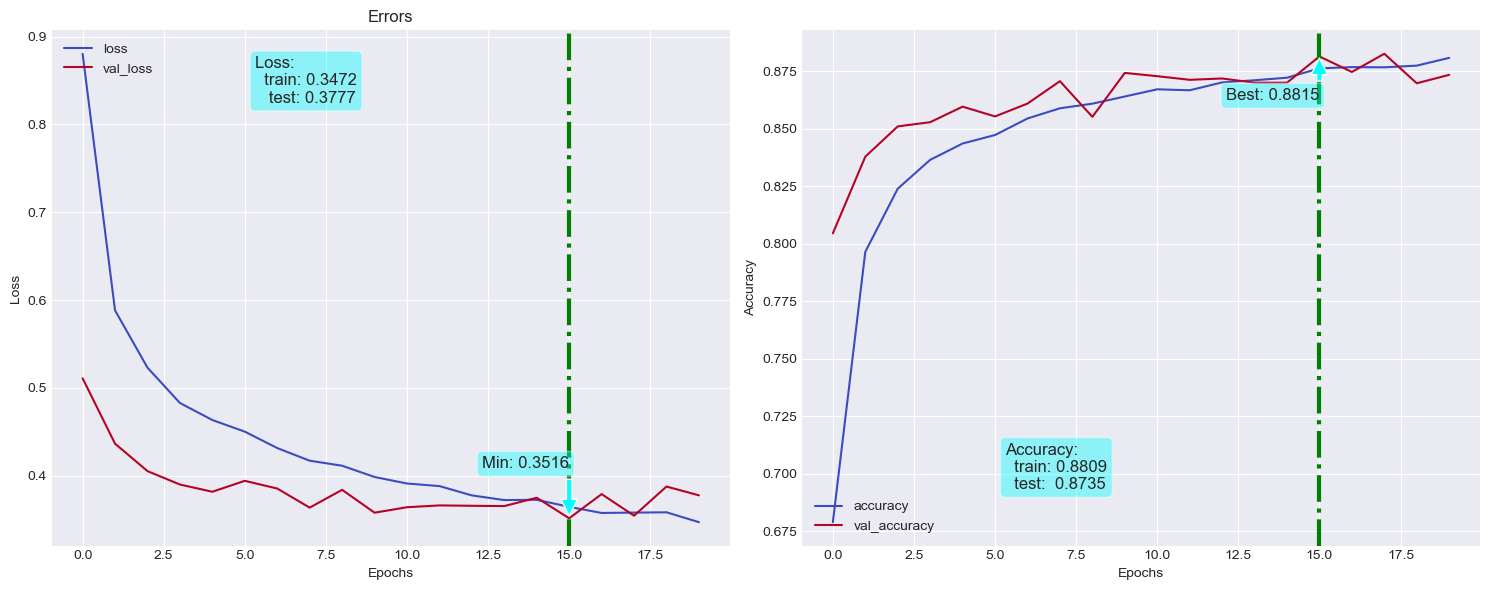

In [88]:
hist_df = pd.DataFrame(history.history) 

display(hist_df.head(3))
display(hist_df.tail(3))

fn_plot_tf_hist(hist_df = hist_df)

$$\text{
Creating the Prediction Model
}
$$

In [89]:
prediction_model = tf.keras.Sequential([
    model,
    tf.keras.layers.Softmax()
])
prediction_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_11 (Functional)      │ (None, 10)             │       409,405 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_5 (Softmax)             │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 409,405 (1.56 MB)

 Trainable params: 409,405 (1.56 MB)

 Non-trainable params: 0 (0.00 B)

$$
\text{
Accuracy and Confusion Matrix
}
$$

Dataset Train
48000 48000
89.80208333333334


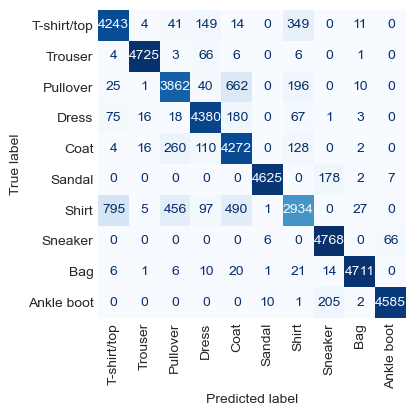

Dataset Test
12000 12000
88.14999999999999


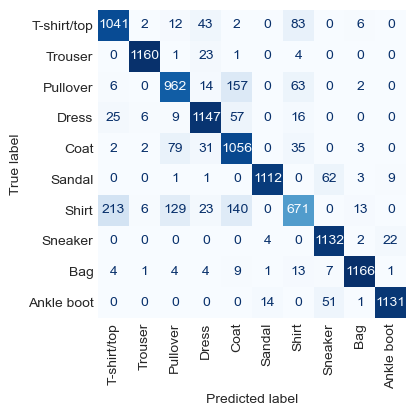

Dataset Validation
10000 10000
88.08


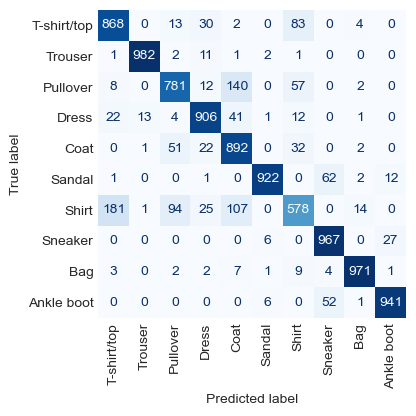

In [90]:
ds = {
    'Train' : train_ds,
    'Test' : test_ds,
    'Validation' : valid_ds
}

for name, data_ds in ds.items():
    print(f'Dataset {name}')
    accuracy_socre_confusion_matrix(data_ds=data_ds, prediction_model=prediction_model, labels=class_names.values())

---
